In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input_output,return_layer_input
import torch
import pandas as pd

In [4]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/hybrid1.pth')
hybrid_model = hybrid_model.cuda()

## Datasets creation

In [5]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [7]:
testneg_classifier_inputs,testneg_ids = return_layer_input('../../Structured/itunes-amazon/'
                                                                         ,'test_negatives',32,hybrid_model,
                                                                        hybrid_model.classifier)#,device=-1)

In [9]:
testpos_classifier_inputs,testpos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'test_positives',32,hybrid_model,
                                                                       hybrid_model.classifier)

In [6]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/itunes-amazon'
                                                                         ,'negatives',128,hybrid_model,
                                                                        hybrid_model.classifier)

In [9]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model,
                                                                       hybrid_model.classifier)

## Utility methods

In [12]:
from utilities_functions.ri_calculator import find_smallest_variation_to_change

## Negative sample analysis

In [14]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in neg_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1),attributes))
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

Processing sample number 287
Processing sample number 288
Processing sample number 289
Processing sample number 290
Processing sample number 291
Processing sample number 292
Processing sample number 293
Processing sample number 294
Processing sample number 295
Processing sample number 296
Processing sample number 297
Processing sample number 298
Processing sample number 299
Processing sample number 300
Processing sample number 301
Processing sample number 302
Processing sample number 303
Processing sample number 304
Processing sample number 305
Processing sample number 306
Processing sample number 307
Processing sample number 308
Processing sample number 309
Processing sample number 310
Processing sample number 311
Processing sample number 312
Processing sample number 313
Processing sample number 314
Processing sample number 315
Processing sample number 316
Processing sample number 317
Processing sample number 318
Processing sample number 319
Processing sample number 320
Processing sam

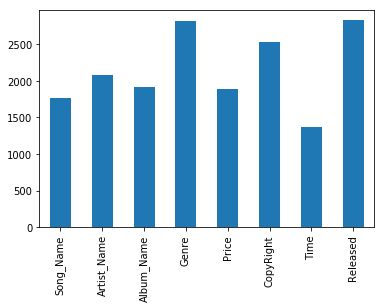

In [16]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
neg_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
neg_variation_df.sum().plot.bar()

In [18]:
neg_variation_df.to_csv('experiments-results/exp3/negatives_ri.csv',index=False)

## Positive samples analisys

In [19]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_matrix = []
for batch in pos_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0),attributes))
        positives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

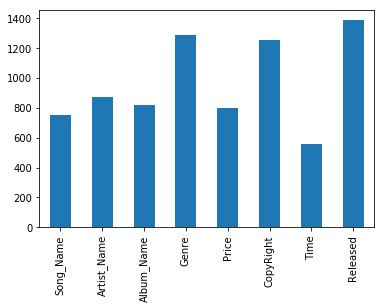

In [20]:
ri_norms_pos = []
for ri_list in positives_ri_matrix:
    ri_norms_pos.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
pos_variation_df = pd.DataFrame(data= ri_norms_pos,columns=attributes)
pos_variation_df.sum().plot.bar()

In [21]:
pos_variation_df.to_csv('experiments-results/exp3/positives_ri.csv',index=False)

## Finding closer vectors

In [22]:
from utilities_functions.distance_measures import nearest_neighbour,nearest_neighbour_onAttribute

In [25]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors = []
i = 0
for batch in neg_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+negatives_ri_matrix[i][attributes.index(att)]
                                                                ,pos_classifier_inputs,attributes.index(att),
                                                                150,'cosine'),attributes))
        negatives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [26]:
# per ogni attributo trovo il più vicino
positives_closer_vectors = []
i = 0
for batch in pos_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+positives_ri_matrix[i][attributes.index(att)]
                                                                ,neg_classifier_inputs,attributes.index(att),
                                                                150,'cosine'),attributes))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [27]:
positives_closer_vectors_df = pd.DataFrame(data= positives_closer_vectors,columns =attributes)
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c:neg_ids[c])
negatives_closer_vectors_df = pd.DataFrame(data = negatives_closer_vectors, columns = attributes)
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c: pos_ids[c])

In [29]:
positives_closer_vectors_df['SampleID'] = pos_ids
negatives_closer_vectors_df['SampleID'] = neg_ids

In [31]:
positives_closer_vectors_df.to_csv('experiments-results/exp3/positives_nn.csv',index=False)
negatives_closer_vectors_df.to_csv('experiments-results/exp3/negatives_nn.csv',index=False)

### Compare nearest neighbours of exp.6 to near. neighbours of exp.3

In [32]:
negatives = pd.read_csv('../../Structured/itunes-amazon/negatives.csv')
positives = pd.read_csv('../../Structured/itunes-amazon/positives.csv')

In [33]:
positives_nn_exp3 = pd.read_csv('experiments-results/exp3/positives_nn.csv')
negatives_nn_exp3 = pd.read_csv('experiments-results/exp3/negatives_nn.csv')
positives_nn_exp6 = pd.read_csv('experiments-results/exp6/positives_numeric_nn.csv')
negatives_nn_exp6 = pd.read_csv('experiments-results/exp6/negatives_numeric_nn.csv')

In [38]:
nn_onAlbum_exp3 = pd.merge(positives_nn_exp3,negatives,left_on='Album_Name',right_on='id')

In [39]:
(nn_onAlbum_exp3['ltable_Album_Name']+" | "+nn_onAlbum_exp3['rtable_Album_Name']).value_counts()

Club Ca n't Handle Me ( feat . David Guetta ) [ From `` Step Up 3D '' ] { The Remixes } - EP | Good Feeling ( Remixes )                                          47
Here 's To the Good Times ... This Is How We Roll ( Deluxe Version ) | This Is How We Roll ( Remix )                                                             37
Mac and Devin Go to High School ( Music from and Inspired By the Movie ) [ Deluxe Version ] | R&G ( Rhythm & Gangsta ) : The Masterpiece ( Explicit Version )    12
Where Are '`` Now ( with Justin Bieber ) [ Remixes ] - EP | Que Que Remix EP                                                                                     10
Hey Mama ( feat . Nicki Minaj , Bebe Rexha & Afrojack ) [ Remixes ] - EP | Hey Mama                                                                               3
Clarity ( Deluxe Edition ) | Clarity                                                                                                                              3
Get Low ( Remixe

In [40]:
nn_onAlbum_exp6 = pd.merge(positives_nn_exp6,negatives,left_on='Album_Name',right_on='id')

In [41]:
(nn_onAlbum_exp6['ltable_Album_Name']+" | "+nn_onAlbum_exp6['rtable_Album_Name']).value_counts()

The Heist ( Deluxe Edition ) | The Heist [ Explicit ]                                                                      19
One Love ( Deluxe Version ) | Pop Love                                                                                     19
The Heist ( Deluxe Edition ) | The Heist [ Clean ]                                                                         16
Fetty Wap ( Deluxe ) | Fetty Wap [ Clean ]                                                                                 12
Hotel Cabana ( Deluxe Version ) | Hotel Cabana [ Explicit ]                                                                10
Slow Down ( Reggae Remixes ) - Single | Good For You ( Remixes )                                                            5
As Long As You Love Me ( Remixes ) [ feat . Big Sean ] | Love Me Like You Do - Made Popular By Ellie Goulding               5
R.O.O.T.S. ( Deluxe Version ) | R.O.O.T.S. ( Route Of Overcoming The Struggle ) ( Amended Amazon Exclusive ) [ Clean ]

In [42]:
negnn_onAlbum_exp6 = pd.merge(negatives_nn_exp6,positives,left_on='Album_Name',right_on='id')

In [45]:
(negnn_onAlbum_exp6['ltable_Album_Name']+" | "+negnn_onAlbum_exp6['rtable_Album_Name']).value_counts().keys()[0:10]

Index(['The Hobbit : The Desolation of Smaug ( Original Motion Picture Soundtrack ) [ Special Edition ] | The Hobbit : The Desolation of Smaug ( Original Motion Picture Soundtrack ) [ Special Edition ]',
       'R.O.O.T.S. ( Deluxe Version ) | R.O.O.T.S. ( Route Of Overcoming The Struggle ) ( Amended Amazon Exclusive ) [ Clean ]',
       'No Shoes , No Shirt , No Problems | No Shoes , No Shirt , No Problems',
       'Greatest Hits , Vol . 1 | Greatest Hits , Vol . 1',
       'Rolling Papers ( Deluxe Version ) | Rolling Papers ( Deluxe ) [ + Video ] [ + Digital Booklet ]',
       'Amaryllis | Amaryllis', 'Be Here | Be Here', 'Blurryface | Blurryface',
       '#NAME ? | #NAME ?',
       'I Do n't Like It , I Love It ( feat . Robin Thicke & Verdine White ) [ Kasum Remix ] - Single | I Do n't Like It , I Love It ( feat . Robin Thicke & Verdine White ) [ Noodles Remix ]'],
      dtype='object')

In [46]:
negnn_onAlbum_exp3 = pd.merge(negatives_nn_exp3,positives,left_on='Album_Name',right_on='id')

In [47]:
(negnn_onAlbum_exp3['ltable_Album_Name']+" | "+negnn_onAlbum_exp3['rtable_Album_Name']).value_counts().keys()[0:10]

Index(['Control | Control', 'Believe | Believe',
       'Anything Goes | Anything Goes', 'Infinity On High | Infinity On High',
       '1989 | 1989', 'Cole Swindell | Cole Swindell', 'Chief | Chief',
       'Fearless | Fearless', 'Slow Down ( Remixes ) | Slow Down Remixes',
       'Believe ( Deluxe Edition ) | Believe'],
      dtype='object')

### Analyze nearest neighbours on artist name

In [ ]:
nn_onArtist = pd.merge(positives_closer_vectors_df,negatives,left_on='Artist_Name',right_on='id')

In [ ]:
nn_onArtist[['ltable_Artist_Name','rtable_Artist_Name']].head(30)

### Nearest Neighbours on Time

In [ ]:
nearest_neighbours_onTime = pd.merge(negatives_closer_vectors_df,positives,left_on='Time',right_on='id')

In [ ]:
nearest_neighbours_onTime['rtable_Time'].unique()

In [ ]:
it,variation = find_smallest_variation_to_change(hybrid_model.classifier,positive_classifier_inputs[0],20,6,0)

In [ ]:
positive_classifier_inputs[0][20].data = positive_classifier_inputs[0][20].data.copy_(positive_classifier_inputs[0][20].data+
                                                                                     variation.data)

In [ ]:
hybrid_model.classifier.forward(positive_classifier_inputs[0])[20]

In [ ]:
grads_list = []
h = positive_classifier_inputs[0].register_hook(lambda g: grads_list.append(g))

In [ ]:
out = hybrid_model.classifier.forward(positive_classifier_inputs[0])
prob = get_probabilites(out[20])

In [ ]:
from torch.autograd import Variable
true_labels = Variable (torch.cuda.FloatTensor([0,1]))